## This compares results from the same image against 2 different algorithms

In [1]:
from PIL import Image
from IPython.display import display
import numpy as np
from skimage.filters import threshold_otsu
import cv2

import sqlite3
import pandas as pd
import geopandas as gpd
from shapely import wkb

import matplotlib.pyplot as plt


from skimage import io, color



## original gvi score

def get_gvi_score(image_path):
    """
    Calculate the Green View Index (GVI) for a given image file.

    Args:
        image_path (str): Path to the image file.

    Returns:
        float: The Green View Index (GVI) score for the given image.
    """
    # Load the image
    original_image = cv2.imread(image_path)

    # Convert to RGB color space
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Calculate ExG (Excess Green)
    r, g, b = cv2.split(rgb_image.astype(np.float32) / 255)
    exg = 2 * g - r - b

    # Apply Otsu's thresholding on ExG
    threshold = threshold_otsu(exg)
    green_pixels = (exg > threshold).sum()
    total_pixels = original_image.shape[0] * original_image.shape[1]

    # Calculate the Green View Index (GVI)
    gvi_score = (green_pixels / total_pixels) * 100

    return gvi_score

In [2]:
def apply_otsu_threshold(matrix):
    return threshold_otsu(matrix)


def filter_otsu_threshold(threshold, floor=50):
    floor = floor / 255
    if threshold < floor:
        return floor
    else:
        return threshold

In [45]:



def preprocess_image(image_path):

    # Load the image
    original_image = cv2.imread(image_path)
    
    # Convert to RGB color space
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    #generate gray scale image
    grayscale_image = color.rgb2gray(rgb_image)
    
    # Calculate ExG (Excess Green)
    r, g, b = cv2.split(rgb_image.astype(np.float32) / 255)
    exg = 2 * g - r - b

    return r, g, b, exg, rgb_image, grayscale_image, original_image



def get_base_gvi_score(image_path, floored=False, floor=50):

    r, g, b, exg, rgb_image, grayscale_image, original_image = preprocess_image(image_path)
    
    threshold = threshold_otsu(exg)

    if floored == True:
        if threshold < (floor / 255):
            threshold = floor / 255
    
    green_pixels = (exg > threshold).sum()
    green_pixel_map = (exg > threshold)
    total_pixels = original_image.shape[0] * original_image.shape[1]
    
    # Calculate the Green View Index (GVI)
    gvi_score = (green_pixels / total_pixels) * 100
    
    return r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map



def get_otsu_on_grayscale_gvi_score(image_path, floored=False, floor=50):

    r, g, b, exg, rgb_image, grayscale_image, original_image = preprocess_image(image_path)
    
    threshold = threshold_otsu(grayscale_image)

    if floored == True:
        if threshold < (floor / 255):
            threshold = floor /255


    green_pixels = (exg > threshold).sum()
    green_pixel_map = (exg > threshold)
    total_pixels = original_image.shape[0] * original_image.shape[1]
    
    # Calculate the Green View Index (GVI)
    gvi_score = (green_pixels / total_pixels) * 100
    
    return r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map


def get_fixed_threshold_gvi_score(image_path, brightness_thresh=50):

    r, g, b, exg, rgb_image, grayscale_image, original_image = preprocess_image(image_path)
    
    #threshold = threshold_otsu(grayscale_image)
    threshold = brightness_thresh / 255


    green_pixels = (exg > threshold).sum()
    green_pixel_map = (exg > threshold)
    total_pixels = original_image.shape[0] * original_image.shape[1]
    
    # Calculate the Green View Index (GVI)
    gvi_score = (green_pixels / total_pixels) * 100
    
    return r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map






In [24]:
def reorder_pixels(r, g, b, exg):
    arrays = [r, g, b, exg]
    for i in range(len(arrays)):
        #print(arrays[i].shape)
        orig_shape = arrays[i].shape
        #flatten the arrays for sorting
        arrays[i] = arrays[i].reshape(1, -1)

    sort_index = np.argsort(arrays[3]) ## sort by exg
    sorted_arrays = [array[:, sort_index[0]] for array in arrays]
    
    for i in range(len(sorted_arrays)):
        print(sorted_arrays[i].shape)
        #reconstruct the original shape
        sorted_arrays[i] = sorted_arrays[i].reshape(orig_shape[0], -1)
    
    r = sorted_arrays[0]
    g = sorted_arrays[1]
    b = sorted_arrays[2]


    
    
    reordered_rgb = np.stack((r, g, b), axis=-1)
    return reordered_rgb

In [43]:
def print_images_baselines(rgb_image, g, exg, reordered_rgb):
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        ax = axes.ravel()
        
        ax[0].imshow(rgb_image, cmap=plt.cm.gray)
        ax[0].set_title('Original Image')
        
        ax[1].imshow(g, cmap=plt.cm.summer)
        ax[1].set_title('Green Channel Image')
    
        ax[2].imshow(exg, cmap=plt.cm.gray)
        ax[2].set_title('Excess Green Image')
    
        ax[3].imshow(reordered_rgb, cmap=plt.cm.gray)
        ax[3].set_title('Reordered Pixels Image')

        
        for a in ax:
            a.axis('off')
        
        plt.show()


def print_sets_of_5_images(one, onet, two, twot, three, threet, four, fourt, five, fivet):
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        ax = axes.ravel()
        
        ax[0].imshow(one, cmap=plt.cm.gray)
        ax[0].set_title(onet)
        
        ax[1].imshow(two, cmap=plt.cm.gray)
        ax[1].set_title(twot)
    
        ax[2].imshow(three, cmap=plt.cm.gray)
        ax[2].set_title(threet)
    
        ax[3].imshow(four, cmap=plt.cm.gray)
        ax[3].set_title(fourt)

        ax[4].imshow(five, cmap=plt.cm.gray)
        ax[4].set_title(fivet)

        
        for a in ax:
            a.axis('off')
        
        plt.show()
    

(1, 3459600)
(1, 3459600)
(1, 3459600)
(1, 3459600)


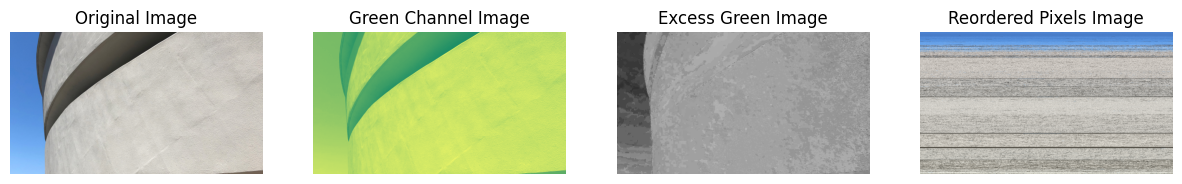

In [81]:
image_path = 'D:\\projects\\street-view-green-view\\data\\raw\\mapillary\\518953222454873.jpeg'
image_path = 'D:\\projects\\geo_image_experiments\\data\\reference_images\\gray_building_veryblue_sky.jpeg'
#image_path = 'D:\\projects\\geo_image_experiments\\data\\reference_images\\original_false_positive.jpeg'
#image_path = 'D:\\projects\\street-view-green-view\\data\\raw\\mapillary\\3724044271054354.jpeg'
#image_path = 'D:\\projects\\geo_image_experiments\\data\\reference_images\\cairo.jpeg'



r, g, b, exg, rgb_image, grayscale_image, original_image = preprocess_image(image_path)
reordered_rgb = reorder_pixels(r, g, b, exg)
print_images_baselines(rgb_image, g, exg, reordered_rgb)

In [82]:
tests = []
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map = get_base_gvi_score(image_path)
tests.append([r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map])
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map = get_base_gvi_score(image_path, floored=True)
tests.append([r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map])
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map = get_otsu_on_grayscale_gvi_score(image_path)
tests.append([r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map])
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map = get_otsu_on_grayscale_gvi_score(image_path, floored=True)
tests.append([r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map])
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map = get_fixed_threshold_gvi_score(image_path)
tests.append([r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score, green_pixel_map])





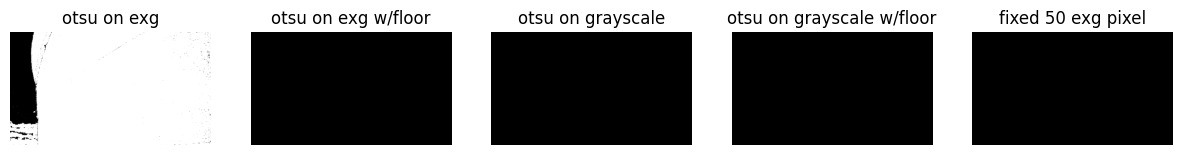

89.72502601456816
-0.031188756


In [84]:
print_sets_of_5_images(tests[0][9],'otsu on exg',tests[1][9],'otsu on exg w/floor',tests[2][9],'otsu on grayscale',tests[3][9],'otsu on grayscale w/floor',tests[4][9],'fixed 50 exg pixel')
print(tests[0][8]) 
print(tests[0][7]) 


In [20]:
## mini-functions
image_path = 'D:\\projects\\geo_image_experiments\\data\\reference_images\\gray_building_veryblue_sky.jpeg'
image_path = 'D:\\projects\\street-view-green-view\\data\\raw\\mapillary\\518953222454873.jpeg'
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score = get_base_gvi_score(image_path)
print(gvi_score)
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score = get_base_gvi_score(image_path, floored=True)
print(gvi_score)
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score = get_otsu_on_grayscale_gvi_score(image_path)
print(gvi_score)
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score = get_otsu_on_grayscale_gvi_score(image_path, floored=True)
print(gvi_score)
r, g, b, exg, rgb_image, grayscale_image, original_image, threshold, gvi_score = get_fixed_threshold_gvi_score(image_path)
print(gvi_score)



99.82479142554013
0.8054169077932098
0.057629243827160496
0.057629243827160496
0.8054169077932098


## END

In [14]:
# Path to your GeoPackage file
baseline_file = "..\\data\\inputs\\Three_Rivers_GVI.gpkg"
test_file = "..\\data\\inputs\\Three_Rivers_GVI_gray.gpkg"

base_image_loc = 'D:\\projects\\street-view-green-view\\data\\raw\\mapillary\\'



In [6]:
def load_results(filepath):
    # Connect to the GeoPackage using sqlite3
    conn = sqlite3.connect(filepath)
    
    # List all tables (layers) in the GeoPackage
    tables_query = "SELECT table_name FROM gpkg_contents WHERE data_type = 'features';"
    tables = pd.read_sql_query(tables_query, conn)
    print("Available layers:", tables['table_name'].tolist())
    
    # Read a specific layer
    layer_name = tables['table_name'][0]  # Replace with the desired layer name
    data_query = f"SELECT * FROM {layer_name};"
    df = pd.read_sql_query(data_query, conn)

    # clean the file up a bit
    df = df[df['image_id'].isna() == False].sort_values('gvi_score', ascending=False).reset_index(drop=True)
    
    # Close the connection
    conn.close()

    return df




In [11]:
df_orig = load_results(baseline_file)
df_test = load_results(test_file)


Available layers: ['Three_Rivers_GVI']
Available layers: ['Three_Rivers_GVI_gray']


In [ ]:
df['gvi_score'].plot(title="GVI Index values over 2600 images")

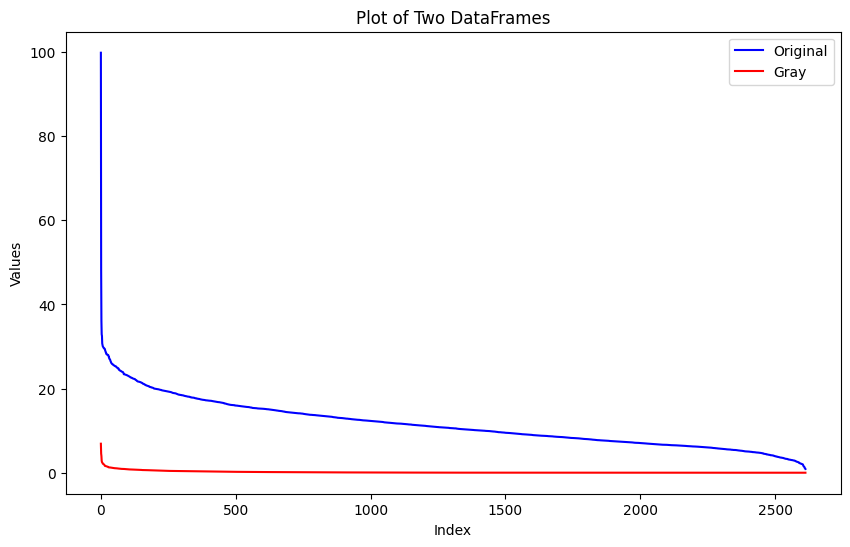

In [13]:
plt.figure(figsize=(10, 6))
# Plot the first DataFrame
plt.plot(df_orig.index, df_orig['gvi_score'], label='Original', color='blue')

# Plot the first DataFrame
plt.plot(df_orig.index, df_test['gvi_score'], label='Gray', color='red')

# Add title and labels
plt.title('Plot of Two DataFrames')
plt.xlabel('Index')
plt.ylabel('Values')

# Add legend
plt.legend()

# Display the plot
plt.show()


In [18]:
def display_image(filepath):

    img = Image.open(filepath)
    img_resized = img.resize((400, 200))
    display(img_resized)


def show_n_results(df, n=5, top=True):
    for i in range(n):
        if top==True:
            pass
        else:
            i = len(df) - (i +1)
        print(i)
        print(df.loc[i].gvi_score)
        print(f"{df.loc[i].filename}")
        display_image(f"{base_image_loc}{df.loc[i].filename}")
    

#n=5
#for i in range(n):
#    print(i)
#    print(df_test.loc[i].gvi_score)
#    print(f"{df_test.loc[i].filename}")
#    display_image(f"{base_image_loc}{df_test.loc[i].filename}")

2612
0.0
1133958103738776.jpeg


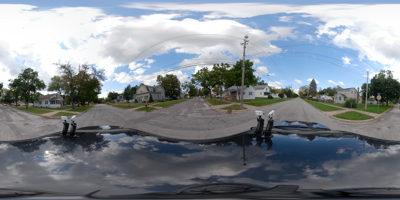

2611
0.0
493202335216241.jpeg


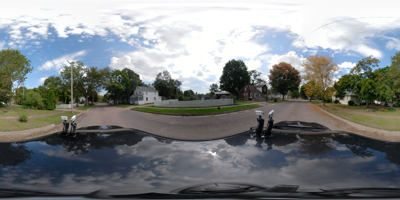

2610
0.0
258389389319506.jpeg


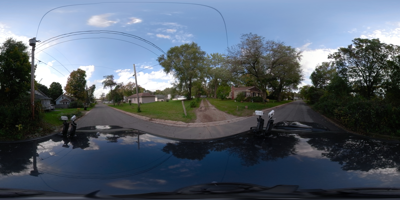

2609
0.0
1910863195749046.jpeg


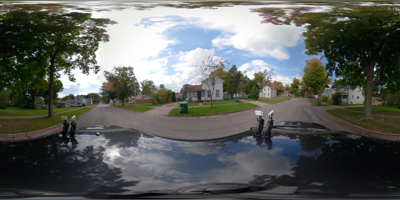

2608
0.0
479523183161535.jpeg


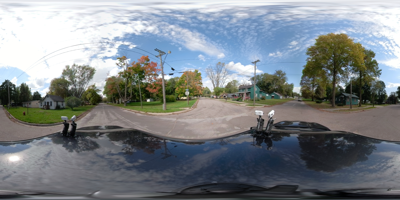

In [20]:
show_n_results(df_test, top=False)

In [ ]:
n=5
for i in range(n):
    i = len(df) - (i +1)
    print(i)
    print(df.loc[i].gvi_score)
    print(df.loc[i].filename)
    display_image(df.loc[i].filename)